# Model optimization

We will optimize our K-means and our Hierarchical clustering models by tuning the hyperparameters. For DBSCAN, it makes no sense to tune the hyperparameters since it only detects one cluster in our data.

In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, inconsistent
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


df_unscaled = pd.read_csv("../data/interim/weather_per_country.csv", index_col=0)
df_standard_scaled = pd.read_csv("../data/processed/X_standard_scaled.csv", index_col=0)
df_tsne = pd.read_csv("../data/processed/X_tsne.csv", index_col=0)
df_umap = pd.read_csv("../data/processed/X_umap.csv", index_col=0)

data = {
    "unscaled": df_unscaled,
    "standard_scaled": df_standard_scaled,
    "tsne": df_tsne,
    "umap": df_umap,
}

## K-Means optimization

K-MEANS PARAMETER OPTIMIZATION
Testing K values: [2, 3, 4, 5, 6, 7, 8]
Initializations per K: 10

K   Inertia    Silhouette   Status
----------------------------------------
2   102.9      0.696        ✅
3   43.8       0.638        ✅
4   26.7       0.587        ✅
5   17.9       0.573        ✅
6   9.8        0.610        ✅
7   7.7        0.585        ✅
8   6.2        0.592        ✅

🎯 Best K: 2 (Silhouette: 0.696)


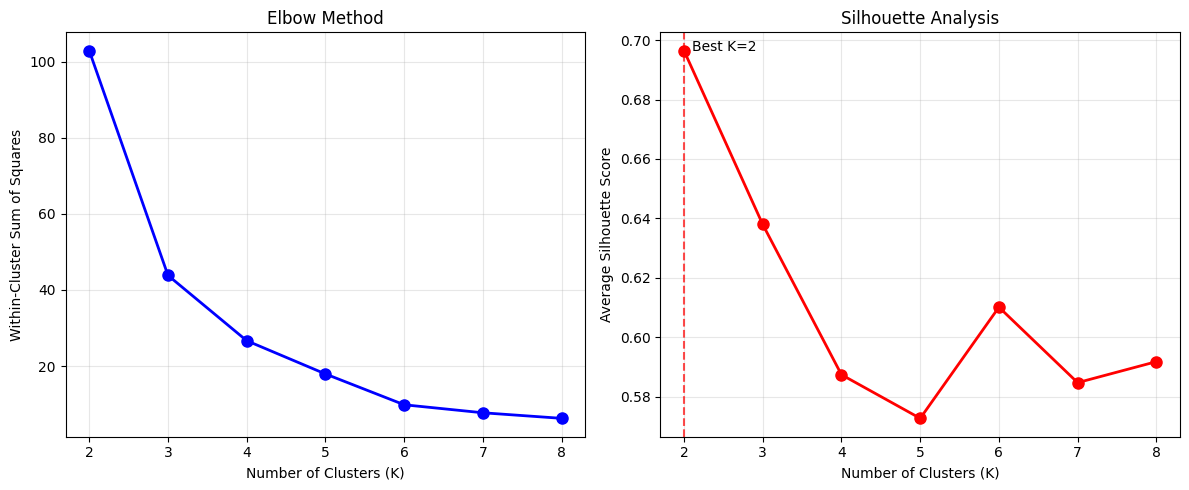


STABILITY VALIDATION (K=2)
-------------------------
Mean ARI (stability): 0.996
Mean Silhouette: 0.696 ± 0.000
✅ High stability


In [2]:
def optimize_kmeans_k(data, k_range=range(2, 11), n_init=10):
    """Systematic K optimization for K-means"""

    print("K-MEANS PARAMETER OPTIMIZATION")
    print("=" * 30)
    print(f"Testing K values: {list(k_range)}")
    print(f"Initializations per K: {n_init}")

    results = {"k_values": [], "inertias": [], "silhouettes": [], "models": {}}

    print(f"\n{'K':<3} {'Inertia':<10} {'Silhouette':<12} {'Status'}")
    print("-" * 40)

    for k in k_range:
        # Fit K-means with multiple initializations
        kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=42)
        labels = kmeans.fit_predict(data)

        # Calculate metrics
        inertia = kmeans.inertia_
        silhouette = silhouette_score(data, labels)

        # Store results
        results["k_values"].append(k)
        results["inertias"].append(inertia)
        results["silhouettes"].append(silhouette)
        results["models"][k] = kmeans

        print(f"{k:<3} {inertia:<10.1f} {silhouette:<12.3f} ✅")

    # Find optimal K by silhouette score
    best_k_idx = np.argmax(results["silhouettes"])
    best_k = results["k_values"][best_k_idx]
    best_silhouette = results["silhouettes"][best_k_idx]

    print(f"\n🎯 Best K: {best_k} (Silhouette: {best_silhouette:.3f})")

    return results, best_k


def visualize_k_optimization(results):
    """Visualize K optimization results"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Elbow plot
    ax1.plot(results["k_values"], results["inertias"], "bo-", linewidth=2, markersize=8)
    ax1.set_title("Elbow Method")
    ax1.set_xlabel("Number of Clusters (K)")
    ax1.set_ylabel("Within-Cluster Sum of Squares")
    ax1.grid(True, alpha=0.3)

    # Silhouette plot
    ax2.plot(
        results["k_values"], results["silhouettes"], "ro-", linewidth=2, markersize=8
    )
    ax2.set_title("Silhouette Analysis")
    ax2.set_xlabel("Number of Clusters (K)")
    ax2.set_ylabel("Average Silhouette Score")
    ax2.grid(True, alpha=0.3)

    # Mark best K on silhouette plot
    best_k_idx = np.argmax(results["silhouettes"])
    best_k = results["k_values"][best_k_idx]
    best_score = results["silhouettes"][best_k_idx]
    ax2.axvline(x=best_k, color="red", linestyle="--", alpha=0.7)
    ax2.text(best_k + 0.1, best_score, f"Best K={best_k}", fontsize=10)

    plt.tight_layout()
    plt.show()


def validate_kmeans_stability(data, k, n_trials=20):
    """Test K-means stability across multiple runs"""

    print(f"\nSTABILITY VALIDATION (K={k})")
    print("-" * 25)

    from sklearn.metrics import adjusted_rand_score

    labels_list = []
    silhouettes = []

    for trial in range(n_trials):
        kmeans = KMeans(n_clusters=k, random_state=trial, n_init=10)
        labels = kmeans.fit_predict(data)
        labels_list.append(labels)
        silhouettes.append(silhouette_score(data, labels))

    # Calculate pairwise ARI for stability
    ari_scores = []
    for i in range(n_trials):
        for j in range(i + 1, n_trials):
            ari = adjusted_rand_score(labels_list[i], labels_list[j])
            ari_scores.append(ari)

    mean_ari = np.mean(ari_scores)
    mean_silhouette = np.mean(silhouettes)
    std_silhouette = np.std(silhouettes)

    print(f"Mean ARI (stability): {mean_ari:.3f}")
    print(f"Mean Silhouette: {mean_silhouette:.3f} ± {std_silhouette:.3f}")

    if mean_ari > 0.8:
        print("✅ High stability")
    elif mean_ari > 0.6:
        print("⚡ Moderate stability")
    else:
        print("⚠️ Low stability - consider different K or algorithm")

    return mean_ari, mean_silhouette


optimization_results, best_k = optimize_kmeans_k(data["umap"], k_range=range(2, 9))
visualize_k_optimization(optimization_results)
stability_ari, stability_sil = validate_kmeans_stability(data["umap"], best_k)

## Hierarchical clustering optimization

HIERARCHICAL CLUSTERING LINKAGE COMPARISON
Method     Silhouette   Balance    Status
---------------------------------------------
single     0.395        1.170      ✅ Good
complete   0.559        0.598      ✅ Good
average    0.581        0.528      ✅ Good
ward       0.572        0.329      ✅ Good

🎯 Best linkage method: average
   Silhouette score: 0.581

DENDROGRAM ANALYSIS (average linkage)


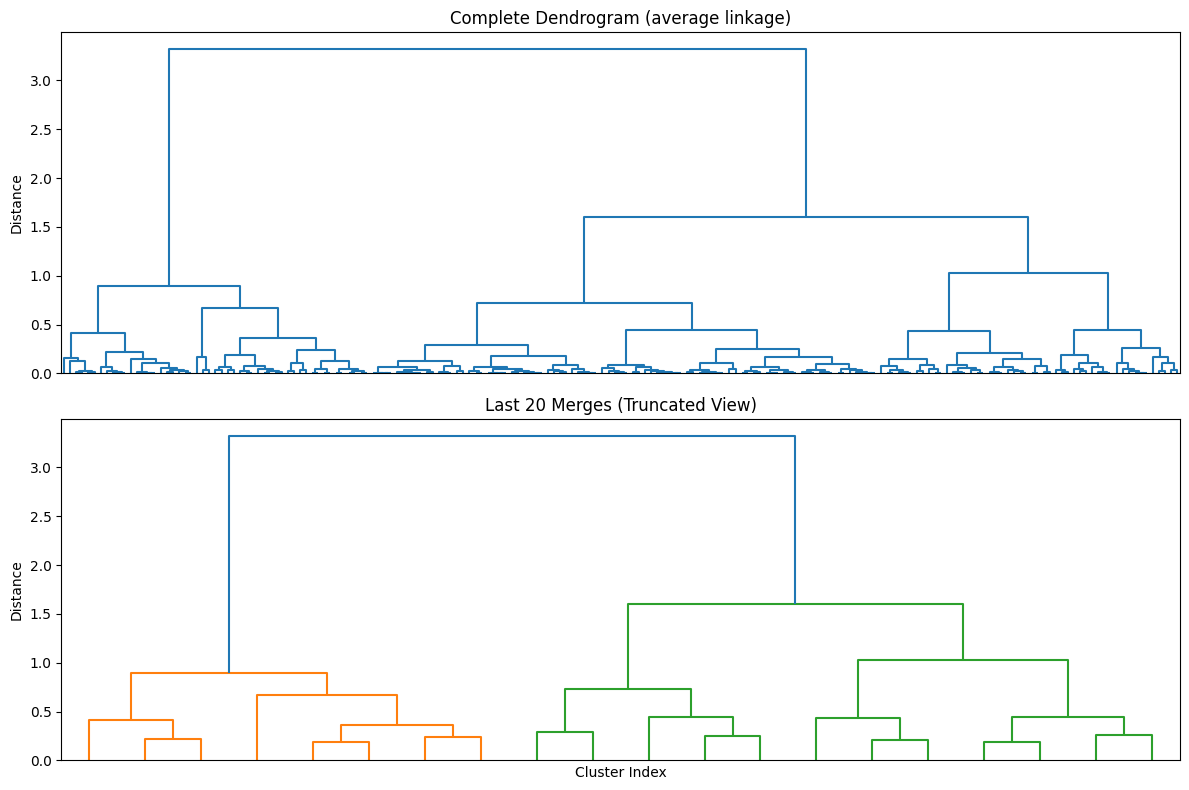


CUT POINT ANALYSIS:
Clusters  Cut Height   Silhouette   Status
---------------------------------------------
2         3.326        0.678        ✅ Good
3         1.603        0.634        ✅ Good
4         1.032        0.581        ✅ Good
5         0.899        0.581        ✅ Good
6         0.727        0.603        ✅ Good
7         0.672        0.577        ✅ Good
8         0.447        0.577        ✅ Good
9         0.443        0.582        ✅ Good
10        0.434        0.578        ✅ Good

🎯 Optimal clusters: 2
   Silhouette score: 0.678

STABILITY VALIDATION (average, K=2)
-------------------------
Mean ARI: 0.863
Mean Silhouette: 0.680


In [19]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.utils import resample


def compare_linkage_methods(data, n_clusters=4):
    """Compare different linkage methods systematically"""

    print("HIERARCHICAL CLUSTERING LINKAGE COMPARISON")
    print("=" * 42)

    linkage_methods = ["single", "complete", "average", "ward"]
    results = {}

    print(f"{'Method':<10} {'Silhouette':<12} {'Balance':<10} {'Status'}")
    print("-" * 45)

    for method in linkage_methods:
        try:
            # Fit hierarchical clustering
            hierarchical = AgglomerativeClustering(
                n_clusters=n_clusters, linkage=method
            )
            labels = hierarchical.fit_predict(data)

            # Calculate metrics
            silhouette = silhouette_score(data, labels)

            # Calculate cluster balance
            cluster_sizes = [np.sum(labels == i) for i in range(n_clusters)]
            balance = np.std(cluster_sizes) / np.mean(cluster_sizes)

            results[method] = {
                "labels": labels,
                "silhouette": silhouette,
                "balance": balance,
                "cluster_sizes": cluster_sizes,
            }

            status = "✅ Good" if silhouette > 0.2 else "⚠️ Poor"
            print(f"{method:<10} {silhouette:<12.3f} {balance:<10.3f} {status}")

        except Exception as e:
            print(f"{method:<10} {'Failed':<12} {'N/A':<10} ❌ Error")
            results[method] = None

    # Find best linkage method
    valid_results = {k: v for k, v in results.items() if v is not None}
    if valid_results:
        best_method = max(
            valid_results.keys(), key=lambda x: valid_results[x]["silhouette"]
        )
        print(f"\n🎯 Best linkage method: {best_method}")
        print(f"   Silhouette score: {valid_results[best_method]['silhouette']:.3f}")

        return results, best_method
    else:
        print("\n❌ No valid linkage methods found")
        return results, None


def create_dendrogram_analysis(data, method="ward", max_clusters=10):
    """Create dendrogram and analyze optimal cut points"""

    print(f"\nDENDROGRAM ANALYSIS ({method} linkage)")
    print("=" * 35)

    # Create linkage matrix
    linkage_matrix = linkage(data, method=method)

    # Plot dendrogram
    plt.figure(figsize=(12, 8))

    # Full dendrogram
    plt.subplot(2, 1, 1)
    dendrogram(linkage_matrix, no_labels=True, color_threshold=0)
    plt.title(f"Complete Dendrogram ({method} linkage)")
    plt.ylabel("Distance")

    # Truncated dendrogram (last 20 merges)
    plt.subplot(2, 1, 2)
    dendrogram(linkage_matrix, truncate_mode="lastp", p=20, no_labels=True)
    plt.title("Last 20 Merges (Truncated View)")
    plt.xlabel("Cluster Index")
    plt.ylabel("Distance")

    plt.tight_layout()
    plt.show()

    # Analyze different cut points
    print(f"\nCUT POINT ANALYSIS:")
    print(f"{'Clusters':<9} {'Cut Height':<12} {'Silhouette':<12} {'Status'}")
    print("-" * 45)

    cut_results = {}

    for n_clusters in range(2, min(max_clusters + 1, len(data))):
        # Get cluster labels for this cut
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        labels = hierarchical.fit_predict(data)

        # Calculate metrics
        silhouette = silhouette_score(data, labels)

        # Estimate cut height (approximate)
        cut_height = linkage_matrix[-(n_clusters - 1), 2]

        cut_results[n_clusters] = {
            "labels": labels,
            "silhouette": silhouette,
            "cut_height": cut_height,
        }

        status = (
            "✅ Good"
            if silhouette > 0.3
            else "⚠️ Fair"
            if silhouette > 0.1
            else "❌ Poor"
        )
        print(f"{n_clusters:<9} {cut_height:<12.3f} {silhouette:<12.3f} {status}")

    # Find optimal number of clusters
    best_n_clusters = max(
        cut_results.keys(), key=lambda x: cut_results[x]["silhouette"]
    )

    print(f"\n🎯 Optimal clusters: {best_n_clusters}")
    print(f"   Silhouette score: {cut_results[best_n_clusters]['silhouette']:.3f}")

    return cut_results, best_n_clusters


def validate_hierarchical_stability(
    data, method, n_clusters, n_iter=20, sample_frac=0.8, random_state=42
):
    """
    Validate hierarchical clustering stability by resampling the dataset and comparing cluster assignments.
    Returns: (mean ARI, mean silhouette)
    """
    rng = np.random.RandomState(random_state)
    aris = []
    silhouettes = []
    base_model = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
    base_labels = base_model.fit_predict(data)
    for i in range(n_iter):
        idx = resample(
            np.arange(len(data)),
            replace=False,
            n_samples=int(sample_frac * len(data)),
            random_state=rng,
        )
        sample = data.iloc[idx] if hasattr(data, "iloc") else data[idx]
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        labels = model.fit_predict(sample)
        # Map sample indices back to original
        base_labels_sub = base_labels[idx]
        ari = adjusted_rand_score(base_labels_sub, labels)
        sil = silhouette_score(sample, labels)
        aris.append(ari)
        silhouettes.append(sil)
    print(f"\nSTABILITY VALIDATION ({method}, K={n_clusters})")
    print("-" * 25)
    print(f"Mean ARI: {np.mean(aris):.3f}")
    print(f"Mean Silhouette: {np.mean(silhouettes):.3f}")
    return np.mean(aris), np.mean(silhouettes)


linkage_results, best_linkage = compare_linkage_methods(data["umap"], n_clusters=4)

if best_linkage:
    cut_analysis, best_n_clusters = create_dendrogram_analysis(
        data["umap"], method=best_linkage
    )
    stability = validate_hierarchical_stability(
        data["umap"], method=best_linkage, n_clusters=best_n_clusters
    )

## Visualize results

/var/folders/zq/s6yvpzhn0wdctd409d0vs5dc0000gn/T/ipykernel_50023/3040045365.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="cluster", y="value", ax=ax, palette="tab10")
/var/folders/zq/s6yvpzhn0wdctd409d0vs5dc0000gn/T/ipykernel_50023/3040045365.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="cluster", y="value", ax=ax, palette="tab10")
/var/folders/zq/s6yvpzhn0wdctd409d0vs5dc0000gn/T/ipykernel_50023/3040045365.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="cluster", y="value"

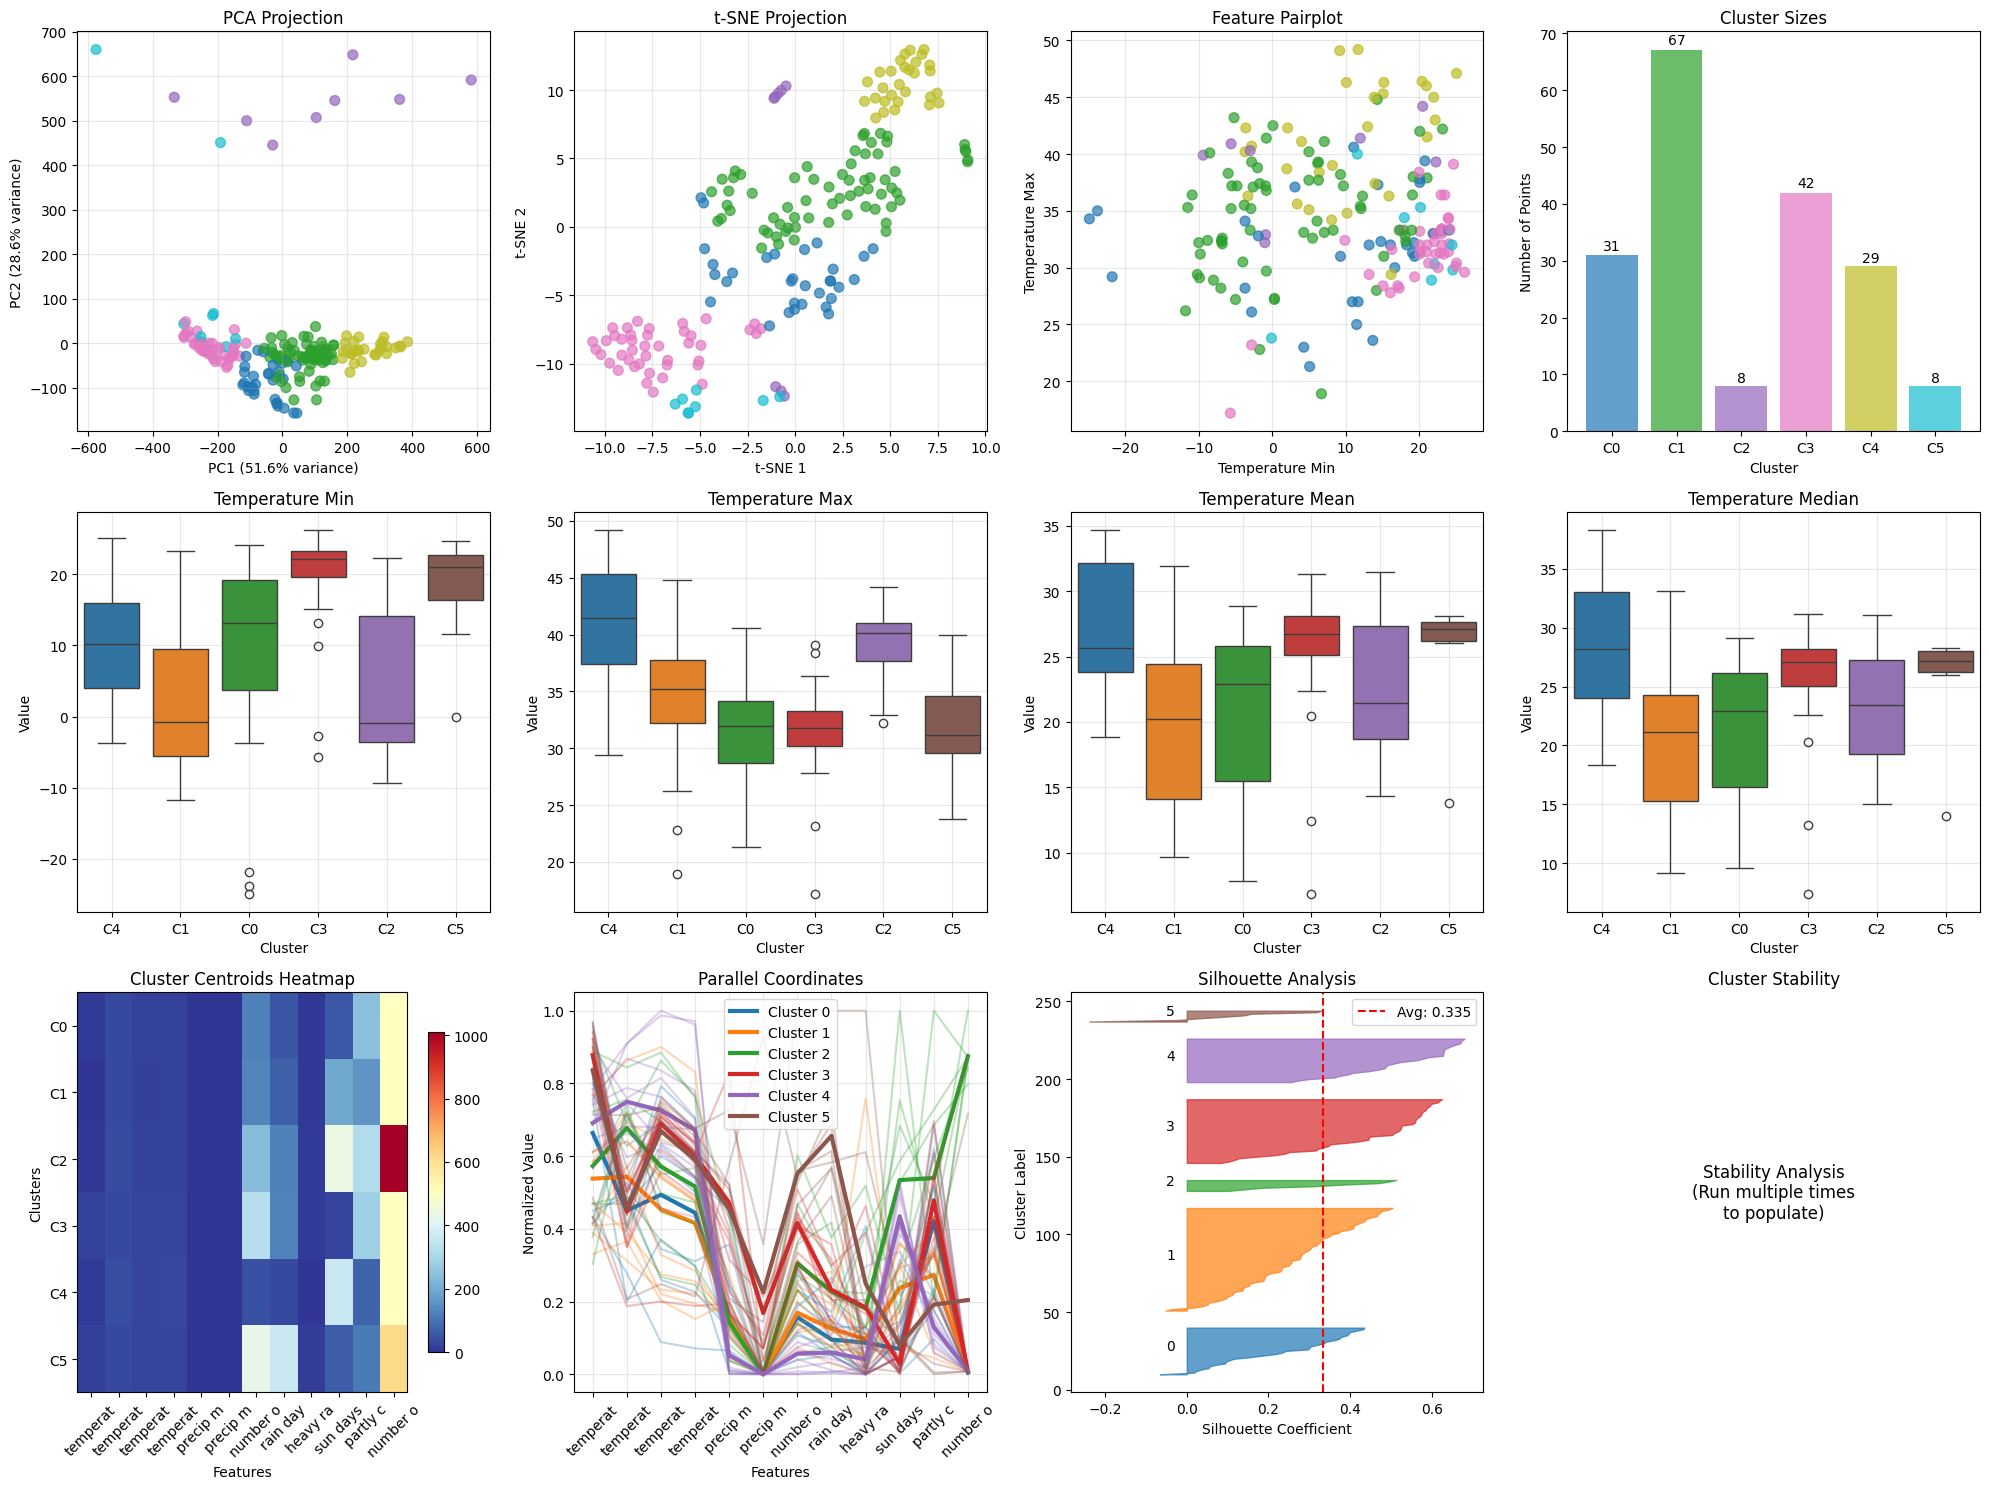

In [40]:
def create_comprehensive_cluster_visualizations(
    data, labels, feature_names, cluster_names=None
):
    """Create a comprehensive set of cluster visualizations"""

    # Set up the plotting grid
    fig = plt.figure(figsize=(20, 15))

    # 1. PCA projection
    ax1 = plt.subplot(3, 4, 1)
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(data)

    scatter = ax1.scatter(
        pca_coords[:, 0], pca_coords[:, 1], c=labels, cmap="tab10", alpha=0.7, s=50
    )
    ax1.set_title("PCA Projection")
    ax1.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    ax1.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    ax1.grid(True, alpha=0.3)

    # 2. t-SNE projection (if data not too large)
    if len(data) <= 1000:  # t-SNE is slow for large datasets
        ax2 = plt.subplot(3, 4, 2)
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(data) // 4))
        tsne_coords = tsne.fit_transform(data)

        ax2.scatter(
            tsne_coords[:, 0],
            tsne_coords[:, 1],
            c=labels,
            cmap="tab10",
            alpha=0.7,
            s=50,
        )
        ax2.set_title("t-SNE Projection")
        ax2.set_xlabel("t-SNE 1")
        ax2.set_ylabel("t-SNE 2")
        ax2.grid(True, alpha=0.3)

    # 3. Feature pairplot (first two features)
    if len(feature_names) >= 2:
        ax3 = plt.subplot(3, 4, 3)
        ax3.scatter(data[:, 0], data[:, 1], c=labels, cmap="tab10", alpha=0.7, s=50)
        ax3.set_title("Feature Pairplot")
        ax3.set_xlabel(feature_names[0].replace("_", " ").title())
        ax3.set_ylabel(feature_names[1].replace("_", " ").title())
        ax3.grid(True, alpha=0.3)

    # 4. Cluster size distribution
    ax4 = plt.subplot(3, 4, 4)
    unique_labels, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    bars = ax4.bar(range(len(unique_labels)), counts, color=colors, alpha=0.7)
    ax4.set_title("Cluster Sizes")
    ax4.set_xlabel("Cluster")
    ax4.set_ylabel("Number of Points")
    ax4.set_xticks(range(len(unique_labels)))
    ax4.set_xticklabels([f"C{i}" for i in unique_labels])

    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + count * 0.01,
            f"{count}",
            ha="center",
            va="bottom",
        )

    # 5-8. Box plots for first 4 features
    for i, feature_idx in enumerate(range(min(4, len(feature_names)))):
        ax = plt.subplot(3, 4, 5 + i)

        # Prepare data for box plot
        df_plot = pd.DataFrame(
            {
                "value": data[:, feature_idx],
                "cluster": [f"C{label}" for label in labels],
            }
        )

        sns.boxplot(data=df_plot, x="cluster", y="value", ax=ax, palette="tab10")
        ax.set_title(f'{feature_names[feature_idx].replace("_", " ").title()}')
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Value")
        ax.grid(True, alpha=0.3)

    # 9. Cluster centroids heatmap
    ax9 = plt.subplot(3, 4, 9)

    # Calculate centroids
    centroids = []
    for label in unique_labels:
        mask = labels == label
        centroid = np.mean(data[mask], axis=0)
        centroids.append(centroid)

    centroids_array = np.array(centroids)

    # Create heatmap
    im = ax9.imshow(centroids_array, cmap="RdYlBu_r", aspect="auto")
    ax9.set_title("Cluster Centroids Heatmap")
    ax9.set_xlabel("Features")
    ax9.set_ylabel("Clusters")
    ax9.set_xticks(range(len(feature_names)))
    ax9.set_xticklabels([f.replace("_", " ")[:8] for f in feature_names], rotation=45)
    ax9.set_yticks(range(len(unique_labels)))
    ax9.set_yticklabels([f"C{i}" for i in unique_labels])

    # Add colorbar
    plt.colorbar(im, ax=ax9, shrink=0.8)

    # 10. Parallel coordinates plot
    ax10 = plt.subplot(3, 4, 10)

    # Normalize data for parallel coordinates
    data_norm = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

    for label in unique_labels:
        mask = labels == label
        cluster_data = data_norm[mask]

        # Plot lines for sample of points (to avoid overcrowding)
        sample_size = min(50, len(cluster_data))
        sample_idx = np.random.choice(len(cluster_data), sample_size, replace=False)

        for i in sample_idx[:10]:  # Plot only first 10 to avoid clutter
            ax10.plot(
                range(len(feature_names)),
                cluster_data[i],
                color=plt.cm.tab10(label),
                alpha=0.3,
            )

        # Plot cluster mean
        mean_line = np.mean(cluster_data, axis=0)
        ax10.plot(
            range(len(feature_names)),
            mean_line,
            color=plt.cm.tab10(label),
            linewidth=3,
            label=f"Cluster {label}",
        )

    ax10.set_title("Parallel Coordinates")
    ax10.set_xlabel("Features")
    ax10.set_ylabel("Normalized Value")
    ax10.set_xticks(range(len(feature_names)))
    ax10.set_xticklabels([f.replace("_", " ")[:8] for f in feature_names], rotation=45)
    ax10.legend()
    ax10.grid(True, alpha=0.3)

    # 11. Silhouette analysis
    ax11 = plt.subplot(3, 4, 11)

    from sklearn.metrics import silhouette_samples

    if len(set(labels)) > 1:
        silhouette_vals = silhouette_samples(data, labels)

        y_lower = 10
        for i, label in enumerate(unique_labels):
            cluster_silhouette_vals = silhouette_vals[labels == label]
            cluster_silhouette_vals.sort()

            size_cluster_i = cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.tab10(i)
            ax11.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                cluster_silhouette_vals,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax11.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))
            y_lower = y_upper + 10

        ax11.set_title("Silhouette Analysis")
        ax11.set_xlabel("Silhouette Coefficient")
        ax11.set_ylabel("Cluster Label")

        # Add vertical line for average silhouette score
        avg_score = np.mean(silhouette_vals)
        ax11.axvline(
            x=avg_score, color="red", linestyle="--", label=f"Avg: {avg_score:.3f}"
        )
        ax11.legend()

    # 12. Cluster stability visualization (if multiple runs available)
    ax12 = plt.subplot(3, 4, 12)
    ax12.text(
        0.5,
        0.5,
        "Stability Analysis\n(Run multiple times\nto populate)",
        ha="center",
        va="center",
        transform=ax12.transAxes,
        fontsize=12,
    )
    ax12.set_title("Cluster Stability")
    ax12.axis("off")

    plt.tight_layout()
    plt.show()

    return pca_coords, centroids_array


labels = KMeans(n_clusters=6, random_state=42).fit_predict(data["unscaled"])
pca_coords, centroids = create_comprehensive_cluster_visualizations(
    data["unscaled"].to_numpy(), labels, data["unscaled"].columns
)